In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from arch import arch_model


In [40]:
def read(file_name):
    xl = 0
    try:
        df = pd.read_excel(f"data/{file_name}.xlsx")
        xl = 1
    except:
        df = pd.read_csv(f"data/{file_name}.csv", sep='|', encoding='utf-8', on_bad_lines='skip')
        xl = 0

    df.columns = df.columns.str.lower()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if xl:
            df['year'] = df['date'].dt.year
    return df



In [4]:
brent = read('brent')
gold = read('gold')
macro = read('macro')
pib = read('pib')
sp = read('sp')

In [5]:
df = sp.merge(pib.drop(columns= 'date'), on = ['year'], how = 'left').drop(columns = 'year')
df = df.merge(macro, on = 'date', how = 'left').drop(columns = 'year')
df = df.merge(gold, on = 'date', how = 'left').drop(columns = 'year')
df = df.merge(brent, on = 'date', how = 'left').dropna(subset = ['close'])


df['volume'] = df['volume'] / df['volume'].rolling(window = 250).mean()
df['gold_volume'] = df['gold_volume'] / df['gold_volume'].rolling(window = 250).mean()
df['brent_volume'] = df['brent_volume'] / df['brent_volume'].rolling(window = 250).mean()

df['cible'] = df['close'].shift(-2)
df['returns'] = df['close'].pct_change() *100
df = df[(df['date'] >= '1999-01-01')].drop(columns = ['year', 'put_call_volume_ratio_cur_day']).dropna(subset= ['cible'])


model = arch_model(df['returns'].dropna(), vol='GARCH', p=1, q=1)
res = model.fit(disp='off')
df['vol'] = res.conditional_volatility

df['date'].is_unique # Ok
df

,date,close,volume,high,low,pe,num_daily_adv_minus_decl,mov_avg_20d,best_eps,dvd_sh_last,...,inflation,gold,gold_pct,gold_volume,brent,brent_pct,brent_volume,cible,returns,vol
2180,1999-01-04,1228.10,1.398027,1248.81,1219.10,27.8209,-14.0,1195.63,43.6168,0.037428,...,1.6,288.3,-0.31,2.078843,10.96,4.08,1.006678,1272.34,-0.091927,1.302934
2181,1999-01-05,1244.78,1.254373,1246.11,1228.10,28.1988,173.0,1199.03,43.6168,0.052075,...,1.6,287.8,-0.17,1.960866,10.53,-3.92,0.993701,1269.73,1.358196,1.221599
2182,1999-01-06,1272.34,1.566773,1272.50,1244.78,28.8231,313.0,1203.26,43.6168,0.282519,...,1.6,288.5,0.24,2.194696,11.46,8.83,1.724803,1275.09,2.214046,1.229650
2183,1999-01-07,1269.73,1.351569,1272.34,1257.68,28.7640,-172.0,1207.68,43.6168,0.077112,...,1.6,292.4,1.35,3.118878,11.53,0.61,1.351260,1263.88,-0.205134,1.371917
2184,1999-01-08,1275.09,1.455050,1278.05,1261.85,28.8857,77.0,1212.26,43.5434,0.000000,...,1.6,292.0,-0.14,2.745741,11.73,1.73,0.910797,1239.51,0.422137,1.287437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144,2025-09-12,6584.29,0.914048,6600.21,6579.49,27.4007,-269.0,6472.55,264.7617,0.269140,...,2.9,3657.3,0.34,0.116476,66.99,0.93,1.267587,6606.76,-0.048273,0.658696
9145,2025-09-15,6615.28,0.881635,6619.62,6602.07,27.5297,-99.0,6480.82,264.8023,1.483275,...,2.9,3689.5,0.88,0.134996,67.44,0.67,0.660995,6600.35,0.470666,0.632124
9146,2025-09-16,6606.76,0.978096,6626.99,6600.11,27.4942,-123.0,6488.70,264.8158,0.236378,...,2.9,3695.5,0.16,0.158740,68.47,1.53,0.975703,6631.96,-0.128793,0.622844
9147,2025-09-17,6600.35,0.961557,6624.39,6551.15,27.4675,75.0,6498.15,264.8423,0.103915,...,2.9,3688.0,-0.20,0.173787,67.95,-0.76,0.745367,6664.36,-0.097022,0.602418


In [29]:
score = pd.read_csv("data/score.csv", sep = '|')
score['date'] = pd.to_datetime(score['date'], errors='coerce').dt.date
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date

data1 = df.merge(score, on = 'date', how = 'left').fillna(0)
data1['momentum_10d'] = data1['close'] - data1['close'].shift(10)
ema_12 = data1['close'].ewm(span=12, adjust=False).mean()
ema_26 = data1['close'].ewm(span=26, adjust=False).mean()
data1['macd'] = ema_12 - ema_26
data1['macd_signal'] = data1['macd'].ewm(span=9, adjust=False).mean()
data1['bb_upper'] = data1['mov_avg_20d'] + 2 * data1['close'].rolling(20).std()
data1['bb_lower'] = data1['mov_avg_20d'] - 2 * data1['close'].rolling(20).std()

data1['mov_avg_100d'] = data1['close'].rolling(window=100).mean()
data1['mov_avg_200d'] = data1['close'].rolling(window=200).mean()

data1['mov_avg_10_50_diff'] = data1['mov_avg_10d'] - data1['mov_avg_50d']
data1['mov_avg_20_50_diff'] = data1['mov_avg_20d'] - data1['mov_avg_50d']
data1['close_minus_10d'] = data1['close'] - data1['mov_avg_10d']
data1['close_minus_20d'] = data1['close'] - data1['mov_avg_20d']
data1['close_minus_30d'] = data1['close'] - data1['mov_avg_30d']
data1['close_minus_50d'] = data1['close'] - data1['mov_avg_50d']
data1['close_minus_100d'] = data1['close'] - data1['mov_avg_100d']  # si calculée
data1['close_minus_200d'] = data1['close'] - data1['mov_avg_200d']

data1

,date,close,volume,high,low,pe,num_daily_adv_minus_decl,mov_avg_20d,best_eps,dvd_sh_last,...,mov_avg_100d,mov_avg_200d,mov_avg_10_50_diff,mov_avg_20_50_diff,close_minus_10d,close_minus_20d,close_minus_30d,close_minus_50d,close_minus_100d,close_minus_200d
0,1999-01-04,1228.10,1.398027,1248.81,1219.10,27.8209,-14.0,1195.63,43.6168,0.037428,...,NaN,NaN,63.83,38.88,7.52,32.47,40.12,71.35,NaN,NaN
1,1999-01-05,1244.78,1.254373,1246.11,1228.10,28.1988,173.0,1199.03,43.6168,0.052075,...,NaN,NaN,66.19,38.96,18.52,45.75,53.73,84.71,NaN,NaN
2,1999-01-06,1272.34,1.566773,1272.50,1244.78,28.8231,313.0,1203.26,43.6168,0.282519,...,NaN,NaN,69.10,39.15,39.13,69.08,77.66,108.23,NaN,NaN
3,1999-01-07,1269.73,1.351569,1272.34,1257.68,28.7640,-172.0,1207.68,43.6168,0.077112,...,NaN,NaN,71.76,39.62,29.91,62.05,72.33,101.67,NaN,NaN
4,1999-01-08,1275.09,1.455050,1278.05,1261.85,28.8857,77.0,1212.26,43.5434,0.000000,...,NaN,NaN,72.23,40.01,30.61,62.83,74.62,102.84,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6714,2025-09-12,6584.29,0.914048,6600.21,6579.49,27.4007,-269.0,6472.55,264.7617,0.269140,...,6126.3042,5984.92600,117.03,87.66,82.37,111.74,146.06,199.40,457.9858,599.36400
6715,2025-09-15,6615.28,0.881635,6619.62,6602.07,27.5297,-99.0,6480.82,264.8023,1.483275,...,6139.5794,5988.15570,125.81,89.21,97.86,134.46,164.47,223.67,475.7006,627.12430
6716,2025-09-16,6606.76,0.978096,6626.99,6600.11,27.4942,-123.0,6488.70,264.8158,0.236378,...,6151.8884,5991.25265,137.40,89.56,70.22,118.06,146.73,207.62,454.8716,615.50735
6717,2025-09-17,6600.35,0.961557,6624.39,6551.15,27.4675,75.0,6498.15,264.8423,0.103915,...,6163.0442,5994.14625,145.11,91.51,48.60,102.20,130.28,193.71,437.3058,606.20375


In [ ]:
# data1 = data1.fillna(0).reset_index(drop=True)
# data1.to_csv("data/df.csv", sep = '|', index= False)

In [ ]:
df = read("df")
df.

,close,cible
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True


In [50]:
df.isna().sum().sum()
len(df.columns.to_list())

49

In [13]:
df.corr()
df[['cible', 'pib', 'pib_pct']]

,cible,pib,pib_pct
2180,1272.34,1.292488e+13,0.045
2181,1269.73,1.292488e+13,0.045
2182,1275.09,1.292488e+13,0.045
2183,1263.88,1.292488e+13,0.045
2184,1239.51,1.292488e+13,0.045
...,...,...,...
9144,6606.76,2.330502e+13,0.028
9145,6600.35,2.330502e+13,0.028
9146,6631.96,2.330502e+13,0.028
9147,6664.36,2.330502e+13,0.028


In [14]:
df = df.dropna(subset= ['cible'])
X = sm.add_constant(df.drop(columns= ['date', 'cible']))
Y = df['cible']

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  cible   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.151e+05
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:59:57   Log-Likelihood:                -33917.
No. Observations:                6719   AIC:                         6.789e+04
Df Residuals:                    6690   BIC:                         6.809e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.8783     17.498      0.164      0.869     -31.423      37.179
close                        0.6801      0.053     12.939      0.000       0.577       0.783
volume                       2.0439      1.703      1.200      0.230      -1.295       5.383
high                         0.1399      0.046      3.049      0.002       0.050       0.230
low                          0.1548      0.041      3.780      0.000       0.075       0.235
pe                           0.2108      0.339      0.622      0.534      -0.454       0.875
num_daily_adv_minus_decl     0.0039      0.004      1.048      0.295      -0.003       0.011
mov_avg_20d                 -0.0202      0.044     -0.464      0.642      -0.106       0.065
best_eps                     0.0017      0.059      0.030      0.976      -0.115       0.118
dvd_sh_last                  1.5472      2.471      0.626      0.531      -3.296       6.391
rsi_3d                       0.0508      0.074      0.685      0.493      -0.095       0.196
rsi_9d                      -0.6218      0.561     -1.108      0.268      -1.722       0.478
rsi_14d                      0.9083      0.835      1.088      0.277      -0.729       2.545
rsi_30d                     -0.4082      0.439     -0.930      0.353      -1.269       0.453
mov_avg_10d                  0.0251      0.031      0.799      0.425      -0.036       0.087
mov_avg_30d                 -0.0479      0.040     -1.211      0.226      -0.126       0.030
mov_avg_50d                  0.0667      0.019      3.531      0.000       0.030       0.104
pb                          -2.5741      2.399     -1.073      0.283      -7.277       2.128
pib_pct                     -0.0973      0.080     -1.223      0.221      -0.253       0.059
pib                       1.814e-13   9.44e-13      0.192      0.848   -1.67e-12    2.03e-12
vix                          0.2420      0.156      1.553      0.121      -0.064       0.547
i                           -1.5526      2.799     -0.555      0.579      -7.039       3.934
i_future                     2.9035      2.827      1.027      0.304      -2.638       8.445
inflation                   -0.7287      0.447     -1.631      0.103      -1.605       0.147
gold                         0.0107      0.003      4.166      0.000       0.006       0.016
gold_pct                     0.6045      0.434      1.394      0.163      -0.246       1.455
gold_volume                  0.7718      0.358      2.156      0.031       0.070       1.474
brent                       -0.1049      0.035     -3.015      0.003      -0.173      -0.037
brent_pct                   -0.0437      0.212     -0.206      0.837      -0.459       0.372
brent_volume                -0.7982      1.251     -0.638      0.523      -3.251       1.654
returns       

                            OLS Regression Results                            
Dep. Variable:                  cible   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.472e+05
Date:                Fri, 26 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:59:57   Log-Likelihood:                -31471.
No. Observations:                6383   AIC:                         6.300e+04
Df Residuals:                    6354   BIC:                         6.320e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

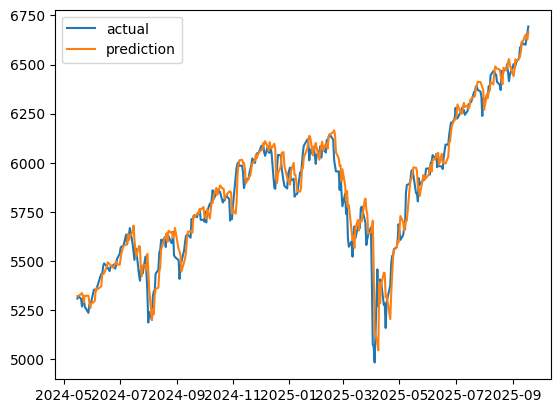

,date,close,volume,high,low,pe,num_daily_adv_minus_decl,mov_avg_20d,best_eps,dvd_sh_last,...,gold,gold_pct,gold_volume,brent,brent_pct,brent_volume,cible,returns,vol,pred
8798,2024-05-16,5297.10,0.959355,5325.49,5296.19,25.3539,-48.0,5134.84,241.6343,1.088037,...,2385.5,-0.39,2.174658,83.27,0.63,1.084168,5308.13,-0.208170,0.786568,5321.130313
8799,2024-05-17,5303.27,0.924078,5305.45,5283.59,25.3834,79.0,5151.64,241.5853,0.222503,...,2417.4,1.34,2.489848,83.98,0.85,0.982480,5321.41,0.116479,0.752764,5322.378278
8800,2024-05-20,5308.13,0.747277,5325.32,5302.40,25.4067,-73.0,5166.52,241.6224,0.450241,...,2438.5,0.87,3.189359,83.71,-0.32,1.061871,5307.01,0.091642,0.716198,5330.352304
8801,2024-05-21,5321.41,0.818136,5324.32,5297.87,25.4703,-2.0,5179.06,241.6032,0.135160,...,2425.9,-0.52,2.598183,82.88,-0.99,1.374137,5267.84,0.250182,0.682886,5336.155335
8802,2024-05-22,5307.01,0.887693,5323.18,5286.01,24.7407,-141.0,5190.83,241.8594,0.073103,...,2392.9,-1.36,2.871745,81.90,-1.18,1.228211,5304.72,-0.270605,0.655779,5322.362958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144,2025-09-12,6584.29,0.914048,6600.21,6579.49,27.4007,-269.0,6472.55,264.7617,0.269140,...,3657.3,0.34,0.116476,66.99,0.93,1.267587,6606.76,-0.048273,0.658696,6617.266699
9145,2025-09-15,6615.28,0.881635,6619.62,6602.07,27.5297,-99.0,6480.82,264.8023,1.483275,...,3689.5,0.88,0.134996,67.44,0.67,0.660995,6600.35,0.470666,0.632124,6650.867151
9146,2025-09-16,6606.76,0.978096,6626.99,6600.11,27.4942,-123.0,6488.70,264.8158,0.236378,...,3695.5,0.16,0.158740,68.47,1.53,0.975703,6631.96,-0.128793,0.622844,6642.393749
9147,2025-09-17,6600.35,0.961557,6624.39,6551.15,27.4675,75.0,6498.15,264.8423,0.103915,...,3688.0,-0.20,0.173787,67.95,-0.76,0.745367,6664.36,-0.097022,0.602418,6628.655497


In [15]:
# 

s = int(len(df) * 0.95)
train = df.iloc[:s].copy()
test = df.iloc[s:].copy()

train = train.dropna(subset= ['cible'])
X = sm.add_constant(train.drop(columns= ['date', 'cible']))
Y = train['cible']

model = sm.OLS(Y, X).fit()
print(model.summary())

test['pred'] = model.predict(sm.add_constant(test.drop(columns= ['date', 'cible'])))

plt.plot(test['date'], test['cible'], label = 'actual')
plt.plot(test['date'], test['pred'], label = 'prediction')
plt.legend()
plt.show()
test

In [18]:
# df.to_csv('donnee_sans_score.csv', index=False, sep = '|')
df

,date,close,volume,high,low,pe,num_daily_adv_minus_decl,mov_avg_20d,best_eps,dvd_sh_last,...,inflation,gold,gold_pct,gold_volume,brent,brent_pct,brent_volume,cible,returns,vol
2180,1999-01-04,1228.10,1.398027,1248.81,1219.10,27.8209,-14.0,1195.63,43.6168,0.037428,...,1.6,288.3,-0.31,2.078843,10.96,4.08,1.006678,1272.34,-0.091927,1.302934
2181,1999-01-05,1244.78,1.254373,1246.11,1228.10,28.1988,173.0,1199.03,43.6168,0.052075,...,1.6,287.8,-0.17,1.960866,10.53,-3.92,0.993701,1269.73,1.358196,1.221599
2182,1999-01-06,1272.34,1.566773,1272.50,1244.78,28.8231,313.0,1203.26,43.6168,0.282519,...,1.6,288.5,0.24,2.194696,11.46,8.83,1.724803,1275.09,2.214046,1.229650
2183,1999-01-07,1269.73,1.351569,1272.34,1257.68,28.7640,-172.0,1207.68,43.6168,0.077112,...,1.6,292.4,1.35,3.118878,11.53,0.61,1.351260,1263.88,-0.205134,1.371917
2184,1999-01-08,1275.09,1.455050,1278.05,1261.85,28.8857,77.0,1212.26,43.5434,0.000000,...,1.6,292.0,-0.14,2.745741,11.73,1.73,0.910797,1239.51,0.422137,1.287437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144,2025-09-12,6584.29,0.914048,6600.21,6579.49,27.4007,-269.0,6472.55,264.7617,0.269140,...,2.9,3657.3,0.34,0.116476,66.99,0.93,1.267587,6606.76,-0.048273,0.658696
9145,2025-09-15,6615.28,0.881635,6619.62,6602.07,27.5297,-99.0,6480.82,264.8023,1.483275,...,2.9,3689.5,0.88,0.134996,67.44,0.67,0.660995,6600.35,0.470666,0.632124
9146,2025-09-16,6606.76,0.978096,6626.99,6600.11,27.4942,-123.0,6488.70,264.8158,0.236378,...,2.9,3695.5,0.16,0.158740,68.47,1.53,0.975703,6631.96,-0.128793,0.622844
9147,2025-09-17,6600.35,0.961557,6624.39,6551.15,27.4675,75.0,6498.15,264.8423,0.103915,...,2.9,3688.0,-0.20,0.173787,67.95,-0.76,0.745367,6664.36,-0.097022,0.602418
